## Imports

In [2]:
import vm_tools as vmt
import cortex as cx
import matplotlib.pyplot as plt
import numpy as np
import nibabel
import copy
import time
import os
import numpy as np
import nibabel as nib


In [3]:
%matplotlib inline

In [4]:
def load_data(filename):
    """ Return fMRI data corresponding to the given filename and prints
        shape of the data array
    ----------
    filename : string 
        This string should be a path to given file. The file must be
        .nii 
    Returns
    -------
    data : numpy array
        An array consisting of the data. 
    """
    img = nib.load(filename)
    data = img.get_data()
    data = data[:,:,:,4:]
    print(data.shape)
    return data

def combine_run_arrays(run_array_lst):
    """ Returns a combined 4d array by concatinating based on time (axis = 3)
    ----------
    run_array_lst : array of 4d numpy arrays 

    Returns
    -------
    4d numpy array 
    """
    return np.concatenate(run_array_lst, axis = 3)

## Get data

In [5]:
#All file strings corresponding to BOLD data for subject 4 
files = ['task001_run001.bold_dico.nii', 'task001_run002.bold_dico.nii', 
         'task001_run003.bold_dico.nii', 'task001_run004.bold_dico.nii', 
         'task001_run005.bold_dico.nii', 'task001_run006.bold_dico.nii',
         'task001_run007.bold_dico.nii', 'task001_run008.bold_dico.nii']

all_data = []
for index, filename in enumerate(files):
    new_data = load_data('../../data/' + filename) #load_data function drops first 4 for us
    num_vols = new_data.shape[-1]
    if index != 0 and index != 7:
        new_num_vols = num_vols - 4   
        new_data = new_data[:,:,:,:new_num_vols] #Drop last 4 volumes for middle runs    
    print(new_data.shape[-1])
    all_data.append(new_data)

combined_runs = combine_run_arrays(all_data) 
# combined_runs = combined_runs[:,:,:,9:] #First 17 seconds are credits/no scene id so drop

(160, 160, 36, 447)
447
(160, 160, 36, 437)
433
(160, 160, 36, 434)
430
(160, 160, 36, 484)
480
(160, 160, 36, 458)
454
(160, 160, 36, 435)
431
(160, 160, 36, 538)
534
(160, 160, 36, 259)
259


In [6]:
combined_runs.shape

(160, 160, 36, 3468)

## Get feature space

In [7]:
# Get stimulus feature spaces
stim_fs_fpath = '/home/yuanwang/projects/OpenfMRI/project-beta-1/description_pp/design_matrix_1.npy'
stim_fs_file = np.load(stim_fs_fpath)
stim_fs_file = stim_fs_file[0:combined_runs.shape[-1],:]

In [8]:
stim_fs_file.shape

(3468, 1155)

## Separate Trainig and testing data

In [9]:
e, v = 3000, 468

In [10]:
stim_fs_est = stim_fs_file[:e,:]
stim_fs_val = stim_fs_file[:v,:]

In [11]:
data_est = combined_runs[...,:e]
data_val = combined_runs[...,:v]

In [12]:
print('Estimation feature space shape: %s'%repr(stim_fs_est.shape))
print('Validation feature space shape: %s'%repr(stim_fs_val.shape))

Estimation feature space shape: (3000, 1155)
Validation feature space shape: (468, 1155)


In [62]:
print('Estimation data shape: %s'%repr(data_est.shape))
print('Validation data shape: %s'%repr(data_val.shape))

Estimation data shape: (160, 160, 36, 3000)
Validation data shape: (160, 160, 36, 468)


## compute variance of data and generate mask

In [28]:
dv = data_val.reshape((160*160*36, 468))


In [ ]:
de = data_est.reshape((160*160*36, 3000))

In [29]:
dv.shape

(921600, 468)

In [42]:
vdv = np.var(dv,axis=1)

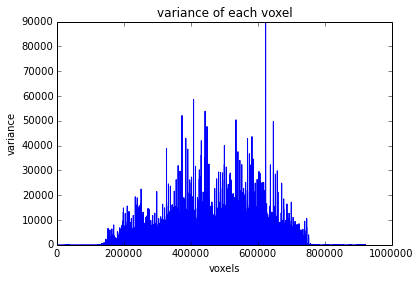

In [48]:
plt.plot(vdv)
plt.title('variance of each voxel')
plt.ylabel('variance')
plt.xlabel('voxels')

In [57]:
mask1000 = vdv>1000
print sum(mask1000)
np.save('../brain_mask/mask34589.npy',mask1000)

34589


In [58]:
mask5000 = vdv>5000
print sum(mask5000)
np.save('../brain_mask/mask3087.npy',mask5000)

3087


In [59]:
mask3000 = vdv>3000
print sum(mask3000)
np.save('../brain_mask/mask6810.npy',mask3000)

6810


## Mask fMRI data

In [63]:
# Mask data
mask = mask1000
data_est_masked = data_est[mask,:]
data_val_masked = data_val[mask,:]
# Show size of masked data
print('Size of masked estimation data is %s'%repr(data_est_masked.shape))
print('Size of masked validation data is %s'%repr(data_val_masked.shape))

MemoryError: 

In [14]:
print('Size of masked estimation data is %s'%repr(data_est_masked.shape))
print('Size of masked validation data is %s'%repr(data_val_masked.shape))

Size of masked estimation data is (1200, 58108)
Size of masked validation data is (90, 58108)


##Set up feature space matrix to do regression

In [15]:
# Create lagged stimulus matrix
efs = vmt.utils.add_lags(stim_fs_est,[2,3,4])
vfs = vmt.utils.add_lags(stim_fs_val,[2,3,4])
# Add column of ones
efs = vmt.utils.add_constant(efs,is_first=True)
vfs = vmt.utils.add_constant(vfs,is_first=True)

## Run regression

In [16]:
alpha = np.logspace(0,6,10)
alpha

array([  1.00000000e+00,   4.64158883e+00,   2.15443469e+01,
         1.00000000e+02,   4.64158883e+02,   2.15443469e+03,
         1.00000000e+04,   4.64158883e+04,   2.15443469e+05,
         1.00000000e+06])

In [17]:
# Run regression 
n_splits = 10 # number of subdivisions of validation data for cross validation of ridge parameter (alpha)
n_resamps = 10 # number of times to compute regression & prediction within training data (can be <= n_splits)
chunk_sz = 10000 # number of voxels to fit at once. Memory-saving.
pthr = 0.005 # Ridge parameter is chosen based on how many voxels are predicted above a correlation threshold 
             # for each alpha value (technically it's slightly more complicated than that, see the code). 
             # This p value sets that correlation threshold.
t0 = time.time()

out = vmt.regression.ridge_cv(efs,data_est_masked,val_fs=vfs,val_data=data_val_masked,alphas=alpha,n_resamps=n_resamps,
                              n_splits=n_splits,chunk_sz=chunk_sz,pthr=pthr,is_verbose=True)

t1 = time.time()
print("Elapsed time is: %d min, %d sec"%((t1-t0)/60,(t1-t0)%60))

Running split 1/10
Running chunk 1 of 6...


/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1057: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/yuanwang/code/vm_tools/Stats/utils.py:24: RuntimeWarning: invalid value encountered in divide
  r = rTmp/n



Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 2/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 3/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 4/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 5/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 6/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 7/10
Running ch

/home/yuanwang/code/vm_tools/regression.py:409: RuntimeWarning: invalid value encountered in greater
  n_sig_vox_byalpha = sum(trncc_byvox>sig_thresh)-sum(trncc_byvox<-sig_thresh)
/home/yuanwang/code/vm_tools/regression.py:409: RuntimeWarning: invalid value encountered in less
  n_sig_vox_byalpha = sum(trncc_byvox>sig_thresh)-sum(trncc_byvox<-sig_thresh)



Best alpha = 46415.888
Computing weights and model predictions...
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Elapsed time is: 103 min, 28 sec


##Make sure estimation procedure chose a reasonable $\alpha$ value
There should be a somewhat obvious maximum in the curve plotted below

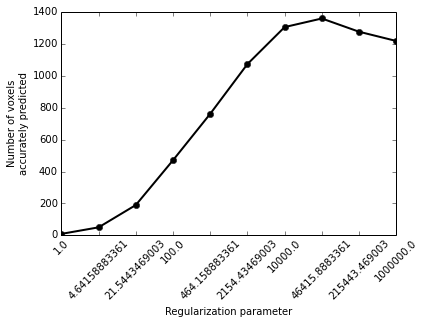

In [18]:
# Plot number of voxels with significant prediction accuracy within the 
# estimation data for each alpha value
na = len(out['n_sig_vox_byalpha'])
plt.plot(range(na),out['n_sig_vox_byalpha'],'ko-',lw=2)
# plt.xticks(range(na),vmt.regression.DEFAULT_ALPHAS,rotation=45)
plt.xticks(range(na),alpha,rotation=45)
plt.xlabel('Regularization parameter')
_ = plt.ylabel('Number of voxels\naccurately predicted')

##Display prediction accuracy results on the cortical surface

In [20]:
out['cc'].shape

(58108,)

(array([  7.00000000e+00,   5.80000000e+01,   2.28000000e+02,
          5.64000000e+02,   1.16400000e+03,   2.37900000e+03,
          4.19000000e+03,   6.35200000e+03,   8.33500000e+03,
          9.05500000e+03,   8.33900000e+03,   6.67400000e+03,
          4.51500000e+03,   2.74600000e+03,   1.46600000e+03,
          8.79000000e+02,   5.13000000e+02,   3.26000000e+02,
          1.95000000e+02,   9.60000000e+01,   2.70000000e+01]),
 array([-0.55591387, -0.49308745, -0.43026104, -0.36743462, -0.30460821,
        -0.24178179, -0.17895538, -0.11612896, -0.05330255,  0.00952387,
         0.07235028,  0.1351767 ,  0.19800311,  0.26082953,  0.32365594,
         0.38648236,  0.44930877,  0.51213519,  0.5749616 ,  0.63778802,
         0.70061443,  0.76344085]),
 <a list of 21 Patch objects>)

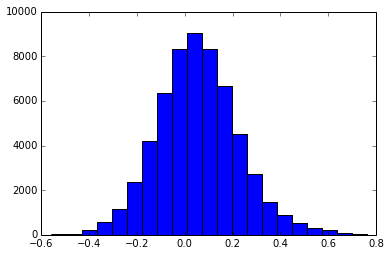

In [21]:
plt.hist(np.nan_to_num(out['cc']),21)

In [22]:
mask.sum()

58108

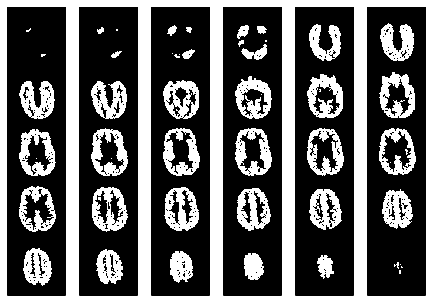

In [23]:
vmt.plot_utils.slice_3d_matrix(mask,0);

In [24]:
# Create pycortex Volume out of predictions
br = np.zeros(mask.shape)
br[mask] = out['cc']

In [34]:
# output the regression output
aff_output_fpath = '/home/yuanwang/projects/affordance/output/af_out_ml_all_w2v3.hdf5'

with h5py.File(aff_output_fpath,'w') as f:
    brDset = f.create_dataset('br', br.shape, br.dtype)
    brDset[:] = br

    weightsDset = f.create_dataset('weights',out['weights'].shape, out['weights'].dtype)
    weightsDset[:] = out['weights']


In [4]:
# input the regression output in the case of firefox crash
with h5py.File('/home/yuanwang/projects/affordance/output/af_out_ml_all.hdf5','r') as hf:
    br = hf['br'].value
    weights = hf['weights'].value.T

In [27]:
br.shape

(30, 100, 100)

In [28]:
br.min()

nan

In [29]:
np.nanmin(br)

-0.55591386556625366

In [30]:
np.nanmax(br)

0.76344084739685059

In [5]:
V = cx.Volume(br,'MLfs2','MLfs2_nb',cmap='hot',vmin=0,vmax=0.6)
# cx.webgl.show(V)

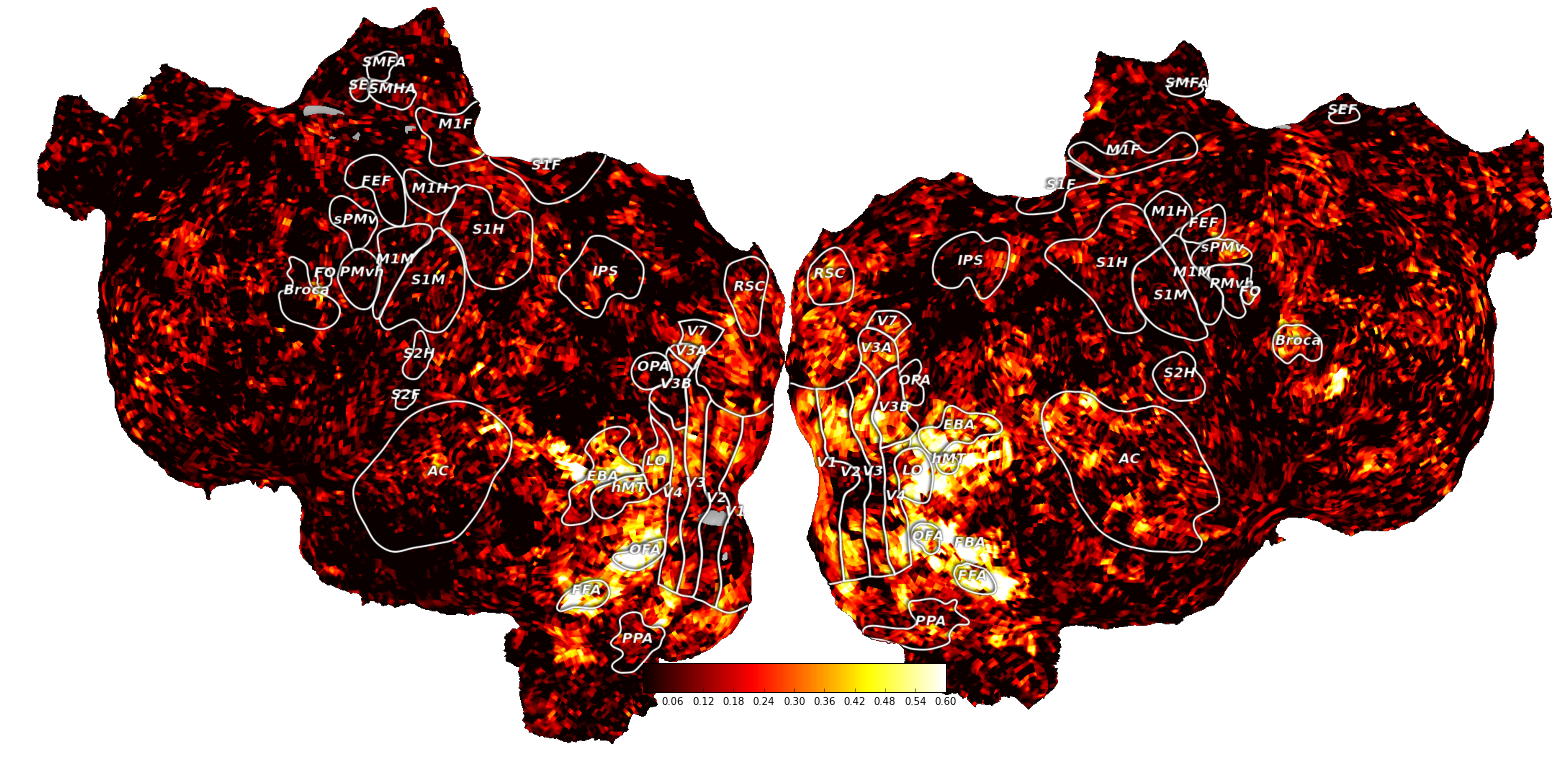

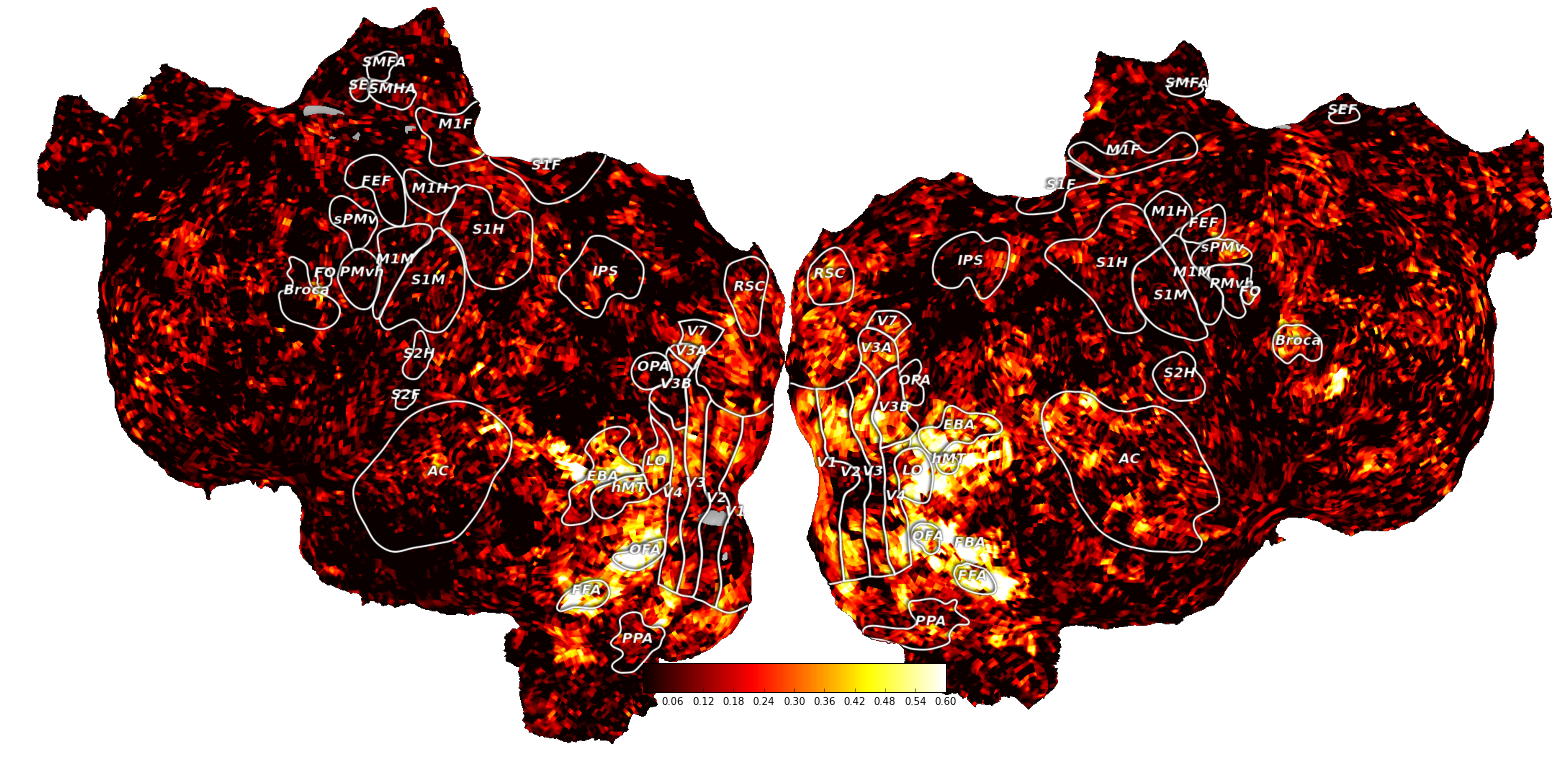

In [7]:
cx.quickflat.make_figure(V,with_curvature=True)

In [8]:
cx.quickflat.make_png('/home/yuanwang/projects/affordance/figure/aff_all_ML.png',V,dpi=300)

## Getting output by ROI

In [52]:
# # import the saved output
# with h5py.File('/home/yuanwang/projects/affordance/output/af_out_ml.hdf5','r') as hf:
#     aff_br = hf['br'].value
#     aff_weights = hf['weights'].value.T

In [9]:
roimasks,roinames = cx.get_roi_masks('MLfs2','MLfs2_nb',Dst='cortical')

Cannot find shapely, using simple label placement
24 voxels cut


/data/shared_code/anaconda/lib/python2.7/site-packages/cortex/svgsplines.py:370: RuntimeWarning: invalid value encountered in double_scalars
  theta = arccos(R/((Q**3)**.5))
/data/shared_code/anaconda/lib/python2.7/site-packages/cortex/svgsplines.py:372: RuntimeWarning: invalid value encountered in double_scalars
  x1 = real(-1.0*(2.0*(Q**.5)*cos(theta/3.0)) - a/3.0)
/data/shared_code/anaconda/lib/python2.7/site-packages/cortex/svgsplines.py:373: RuntimeWarning: invalid value encountered in double_scalars
  x2 = real(-1.0*(2.0*(Q**.5)*cos((theta + 2.0*pi)/3.0)) - a/3.0)
/data/shared_code/anaconda/lib/python2.7/site-packages/cortex/svgsplines.py:374: RuntimeWarning: invalid value encountered in double_scalars
  x3 = real(-1.0*(2.0*(Q**.5)*cos((theta - 2.0*pi)/3.0)) - a/3.0)
/data/shared_code/anaconda/lib/python2.7/site-packages/cortex/svgsplines.py:370: RuntimeWarning: invalid value encountered in arccos
  theta = arccos(R/((Q**3)**.5))
/data/shared_code/anaconda/lib/python2.7/site-pack

In [19]:
roinames

{'AC': 21,
 'ATFP': 9,
 'Broca': 4,
 'EBA': 29,
 'FEF': 1,
 'FFA': 35,
 'FO': 10,
 'IFSFP': 26,
 'IPS': 32,
 'LO': 13,
 'M1F': 2,
 'M1H': 3,
 'M1M': 6,
 'OFA': 22,
 'OPA': 33,
 'PMvh': 14,
 'PPA': 11,
 'RSC': 30,
 'S1F': 28,
 'S1H': 25,
 'S1M': 27,
 'SEF': 12,
 'SMFA': 5,
 'SMHA': 34,
 'V1': 15,
 'V2': 16,
 'V3': 17,
 'V3A': 7,
 'V3B': 8,
 'V4': 18,
 'V7': 19,
 'VO': 24,
 'hMT': 23,
 'pSTS': 20,
 'sPMv': 31}

In [20]:
roi_list = ['EBA','FFA', 'OFA', 'V1','V2','V3','V4','LO']

In [25]:
aff_weights.shape

(58108, 1666)

In [94]:
mkd = np.zeros(roimasks.shape)
# for roi in roi_list:
m_eba = roimasks==roinames[roi_list[0]]
mkd[m_eba] = out['cc']

ValueError: NumPy boolean array indexing assignment cannot assign 49084 input values to the 186 output values where the mask is true

In [87]:
m_eba.shape

(32, 100, 100)

In [89]:
out['cc'].shape

(49084,)

In [90]:
mask.shape

(32, 100, 100)

In [92]:
mkd.shape

(32, 100, 100)

In [93]:
mkd = np.zeros(roimasks.shape)

In [38]:
np.shape(aff_weights)

(58108, 1666)

In [36]:
mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, 

In [22]:
rois = vmt.ROISet.from_pycortex('AH','NaturalMovies','AHfs','AHfs_nb')
rois

17 voxels cut


<vmt.ROISet>
    sub_id : 'AH'
   surf_id : 'AHfs'
       exp : 'NaturalMovies'
       xfm : 'AHfs_nb'
 roi_names : ['FEF', 'M1F', 'M1H', 'Broca', 'SMFA', 'M1M', 'V3A', 'V3B', 'ATFP', 'FO', 'PPA', 'SEF', 'LO', 'PMvh', 'V1', 'V2', 'V3', 'V4', 'V7', 'pSTS', 'AC', 'OFA', 'hMT', 'VO', 'S1H', 'IFSFP', 'S1M', 'S1F', 'EBA', 'RSC', 'sPMv', 'IPS', 'OPA', 'SMHA', 'FFA']
      path : None
       _id : None
data_fields : []

In [63]:
rois['V1'].shape

(32, 100, 100)

In [86]:
mg = np.zeros(v1_mask.shape)
mg[v1_mask] = n2n(rois['V1'].cc)

ValueError: shape mismatch: value array of shape (598,) could not be broadcast to indexing result of shape (32,100,100,100,100)

## Display prediction accuracy by ROI 
This makes use of the ROISet class within vm_tools, which is useful for splitting data into ROIs

In [67]:
rois = vmt.ROISet.from_pycortex('AH','NaturalMovies','AHfs','AHfs_nb')

17 voxels cut


In [68]:
# Apply roi mask to estimated correlation coefficients and weights
rois.apply_mask(pre_mask=mask,cc=out['cc'],weights=out['weights'])

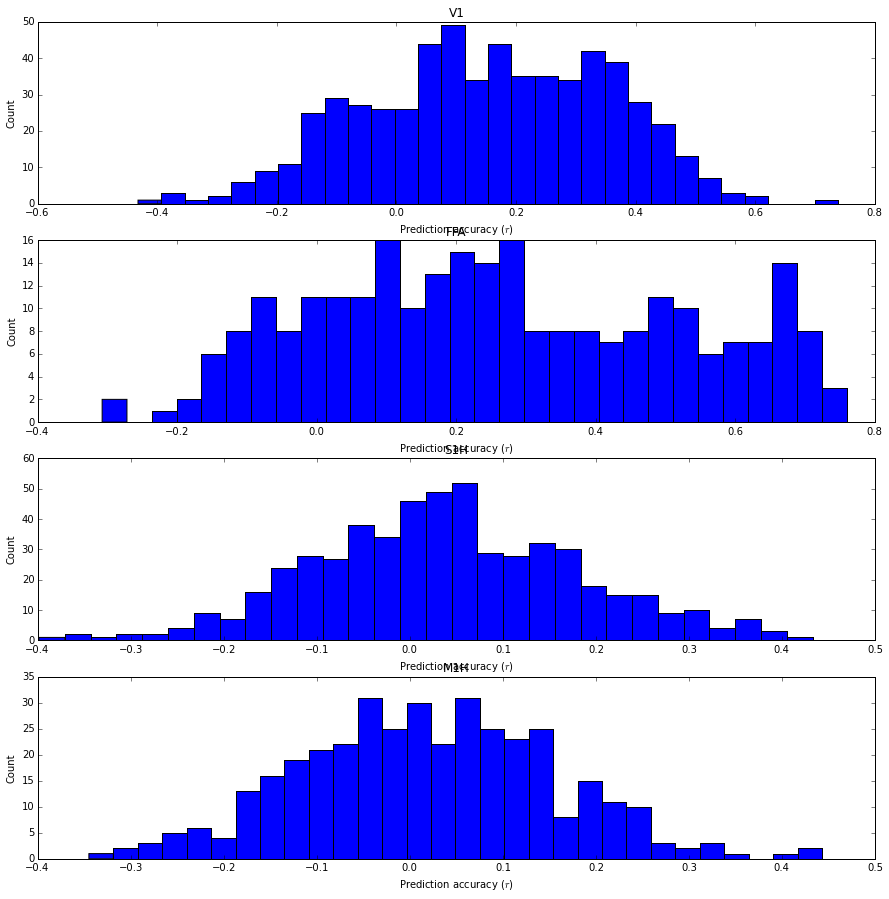

In [69]:
# Show prediction accuracy for V1 voxels and for FFA voxels
n2n = np.nan_to_num
rois_to_plot = ['V1','FFA','S1H','M1H']
fig = plt.figure(figsize=(15,15))
for iroi,roi in enumerate(rois_to_plot):
    plt.subplot(len(rois_to_plot),1,iroi+1)
    plt.hist(n2n(rois[roi].cc),30)
    plt.xlabel('Prediction accuracy ($r$)')
    plt.ylabel('Count')
    _ = plt.title(roi)

#Weight visualization

In [23]:
gab,pp = vmt.viz.load_gabor(stim_fs_val_file)

NameError: name 'vox' is not defined

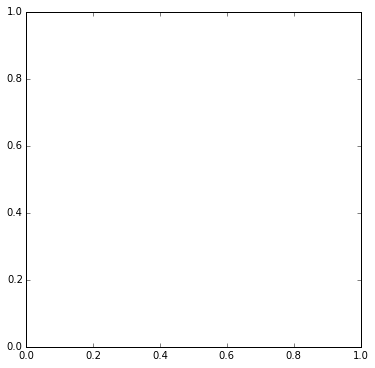

In [24]:
h = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
# Prep weights for display
vox = np.argmax(
avgwts = vmt.utils.avg_wts(out['weights'].T[vox]),
                   Mode='wholematrixrespectzero')/2.0+0.5
vmt.viz.show_gabor(to_plot,pp,bgcol=(0.5,0.5,0.5),ax=ax)
plt.title('$r$ = %0.2f'%out['cc'][vox])

In [49]:
DEFAULT_ALPHAS=np.array([0]+[2**x for x in range(10,21)])

In [50]:
DEFAULT_ALPHAS

array([      0,    1024,    2048,    4096,    8192,   16384,   32768,
         65536,  131072,  262144,  524288, 1048576])